### CNN


#### Reading an input image

======= original image shape =======
Image dimensions: (300, 451, 3)


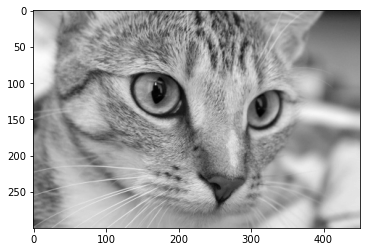

======= rbg2g image shape =======
(300, 451)


In [1]:
import skimage.data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Read image

img = skimage.data.chelsea()
print('======= original image shape =======')
print('Image dimensions:', img.shape)

# Convert to grayscale

img = skimage.color.rgb2gray(img)
plt.imshow(img, cmap='gray')
plt.show()
print('======= rbg2g image shape =======')
print(img.shape)

In [2]:
l1_filters = np.zeros((2,3,3))
l1_filters[0, :, :] = np.array([[[-1, 0, 1], 
                                 [-2, 0, 2], 
                                 [-1, 0, 1]]])

print(l1_filters)

l1_filters[1, :, :] = np.array([[[-1, -2, -1], 
                                 [ 0,  0,  0], 
                                 [ 1,  2,  1]]])
print(l1_filters)

[[[-1.  0.  1.]
  [-2.  0.  2.]
  [-1.  0.  1.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]
[[[-1.  0.  1.]
  [-2.  0.  2.]
  [-1.  0.  1.]]

 [[-1. -2. -1.]
  [ 0.  0.  0.]
  [ 1.  2.  1.]]]


### Conv layer feedforward step

In [4]:
# Perform stride 1 cross correlation of an image and a filter. We output the valid region only
# (no padding).

def convolve(img, conv_filter):
    stride = 1
    padding = 0
    filter_size = conv_filter.shape[1] #3
    results_dim = ((np.array(img.shape) - np.array(conv_filter.shape) + (2*padding))/stride) + 1
#     print('result_dim',results_dim)
    result = np.zeros((int(results_dim[0]), int(results_dim[1])))
    
    for r in np.arange(0, img.shape[0] - filter_size + 1):
        for c in np.arange(0, img.shape[1]-filter_size + 1):          
            curr_region = img[r:r+filter_size,c:c+filter_size] # region of the image when filter is placed on top
#             print('image region',f'ima[{r}:{r+filter_size},{c}:{c+filter_size}]')
#             print('conv_filter',conv_filter)
            curr_result = curr_region * conv_filter
#             print('curr_result',curr_result)
            conv_sum = np.sum(curr_result)
#             print('conv_sum', conv_sum)
            result[r, c] = conv_sum
#             print(f'result[{r},{c}]')
            
    return result       

# Perform convolution with a set of filters and return the result

def conv(img, conv_filters):
    # Check shape of inputs
    if len(img.shape) != len(conv_filters.shape) - 1: 
        raise Exception("Error: Number of dimensions in conv filter and image do not match.")  

    # Ensure filter depth is equal to number of channels in input
    if len(img.shape) > 2 or len(conv_filters.shape) > 3:
        ### if more complex
        if img.shape[-1] != conv_filters.shape[-1]:
            ####451 != 3
            raise Exception("Error: Number of channels in both image and filter must match.")
            
    # Ensure filters are square
    if conv_filters.shape[1] != conv_filters.shape[2]: 
        raise Exception('Error: Filter must be square (number of rows and columns must match).')

    # Ensure filter dimensions are odd
    if conv_filters.shape[1]%2==0: ###### should be odd (center spot)
        raise Exception('Error: Filter must have an odd size (number of rows and columns must be odd).')

    # Prepare output
    feature_maps = np.zeros((img.shape[0]-conv_filters.shape[1]+1, 
                             img.shape[1]-conv_filters.shape[1]+1, 
                             conv_filters.shape[0]))

    # Perform convolutions
    for filter_num in range(conv_filters.shape[0]):
        curr_filter = conv_filters[filter_num, :]
#         print('len curr filter .shape',len(curr_filter.shape))
        # Our convolve function only handles 2D convolutions. If the input has multiple channels, we
        # perform the 2D convolutions for each input channel separately then add them. If the input
        # has just a single channel, we do the convolution directly.
        if len(curr_filter.shape) > 2: #loop at different chanels if more than2D conv
            conv_map = convolve(img[:, :, 0], curr_filter[:, :, 0])
            print('in this loop')
            for ch_num in range(1, curr_filter.shape[-1]): #add them  after conv 
                conv_map = conv_map + convolve(img[:, :, ch_num], 
                                      curr_filter[:, :, ch_num])
        else:
            conv_map = convolve(img, curr_filter) #else just do normal 2D, so no need to sum
        feature_maps[:, :, filter_num] = conv_map

    return feature_maps

2
451
3
3
Convolutional feature maps shape: (298, 449, 2)


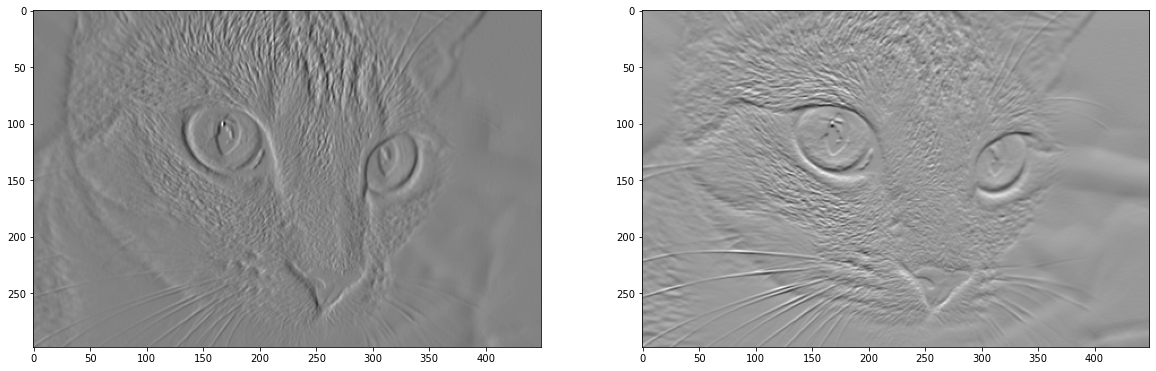

time taken:  3.376704712980427


In [5]:
import timeit
starttime = timeit.default_timer()
features = conv(img, l1_filters)
timetaken = timeit.default_timer()-starttime

print(len(img.shape))
print(img.shape[-1])
print(len(l1_filters.shape))
print(l1_filters.shape[-1])

print('Convolutional feature maps shape:', features.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(features[:,:,0], cmap='gray')
ax2.imshow(features[:,:,1], cmap='gray')
plt.show()
print('time taken: ', timetaken)

### Pooling and relu

In [6]:
# Pooling layer with particular size and stride

def pooling(feature_map, size=2, stride=2): #size of max = 2x2
    # Unsigned integer (0 to 18446744073709551615)
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride+1),
                         np.uint16((feature_map.shape[1]-size+1)/stride+1),
                         feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]): # the last dimension of feature_map is the number of filters
        r2 = 0
        for r in np.arange(0,feature_map.shape[0]-size+1, stride): #step moving by number of stride
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r+size,  c:c+size, map_num]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

# ReLU activation function

def relu(feature_map):
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0,feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    return relu_out

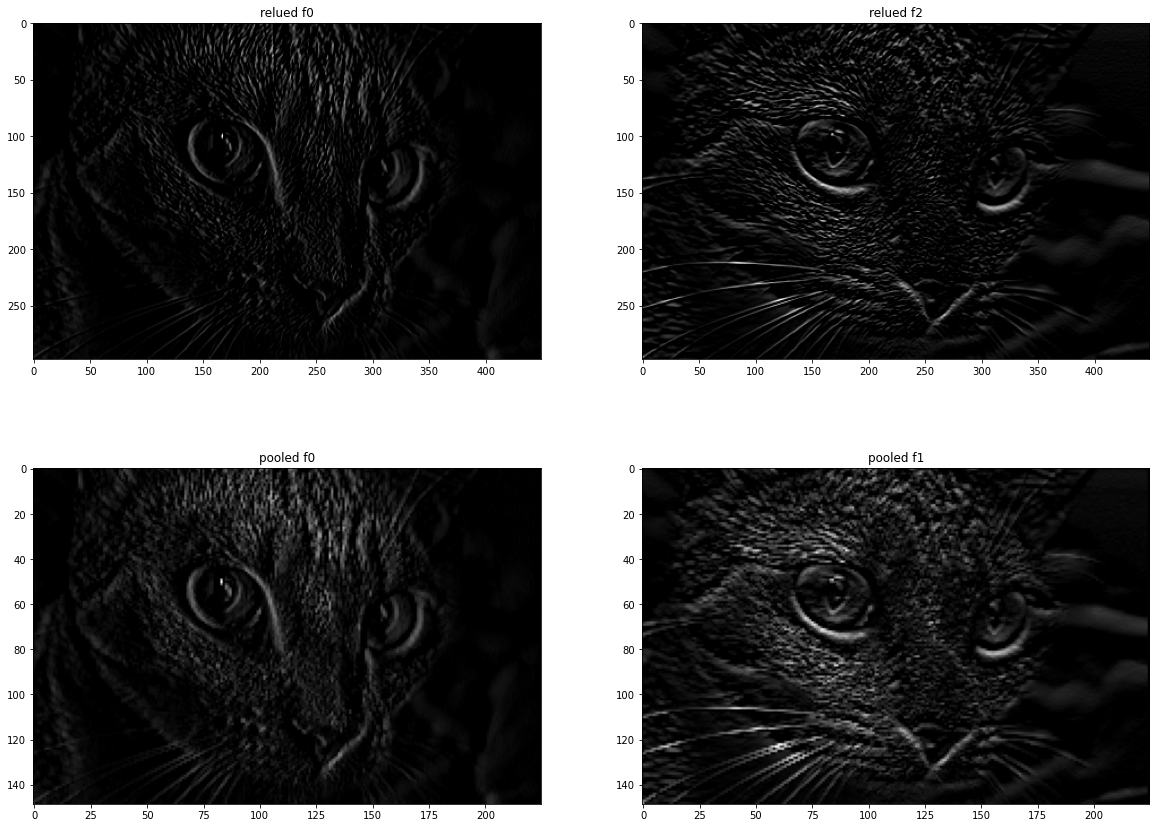

In [7]:
relued_features = relu(features)
pooled_features = pooling(relued_features)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
ax1.imshow(relued_features[:,:,0], cmap='gray')
ax1.set_title('relued f0')
ax2.imshow(relued_features[:,:,1], cmap='gray')
ax2.set_title('relued f2')
ax3.imshow(pooled_features[:,:,0], cmap='gray')
ax3.set_title('pooled f0')
ax4.imshow(pooled_features[:,:,1], cmap='gray')
ax4.set_title('pooled f1')
plt.show()


In [8]:
# First conv layer

print("conv layer 1...")
l1_feature_maps = conv(img, l1_filters)
print('l1_feature_maps',l1_feature_maps.shape)
l1_feature_maps_relu = relu(l1_feature_maps)
print('l1_feature_maps_relu',l1_feature_maps_relu.shape)
l1_feature_maps_relu_pool = pooling(l1_feature_maps_relu, 2, 2)
print('l1_feature_maps_relu_pool',l1_feature_maps_relu_pool.shape)

# Second conv layer

print("conv layer 2...")
l2_filters = np.random.rand(3, 5, 5, l1_feature_maps_relu_pool.shape[-1])
print('l2_filters',l2_filters.shape)
l2_feature_maps = conv(l1_feature_maps_relu_pool, l2_filters)
print('l2_feature_maps',l2_feature_maps.shape)
l2_feature_maps_relu = relu(l2_feature_maps)
print('l2_feature_maps_relu',l2_feature_maps_relu.shape)
l2_feature_maps_relu_pool = pooling(l2_feature_maps_relu, 2, 2)
print('l2_feature_maps_relu_pool',l2_feature_maps_relu_pool.shape)
# Third conv layer

print("conv layer 3...")
l3_filters = np.random.rand(1, 7, 7, l2_feature_maps_relu_pool.shape[-1])
print('l3_filters',l3_filters.shape)
l3_feature_maps = conv(l2_feature_maps_relu_pool, l3_filters)
print('l3_feature_maps',l3_feature_maps.shape)
l3_feature_maps_relu = relu(l3_feature_maps)
print('l3_feature_maps_relu',l3_feature_maps_relu.shape)
l3_feature_maps_relu_pool = pooling(l3_feature_maps_relu, 2, 2)
print('l3_feature_maps_relu_pool',l3_feature_maps_relu_pool.shape)

conv layer 1...
l1_feature_maps (298, 449, 2)
l1_feature_maps_relu (298, 449, 2)
l1_feature_maps_relu_pool (149, 225, 2)
conv layer 2...
l2_filters (3, 5, 5, 2)
in this loop
in this loop
in this loop
l2_feature_maps (145, 221, 3)
l2_feature_maps_relu (145, 221, 3)
l2_feature_maps_relu_pool (73, 111, 3)
conv layer 3...
l3_filters (1, 7, 7, 3)
in this loop
l3_feature_maps (67, 105, 1)
l3_feature_maps_relu (67, 105, 1)
l3_feature_maps_relu_pool (34, 53, 1)


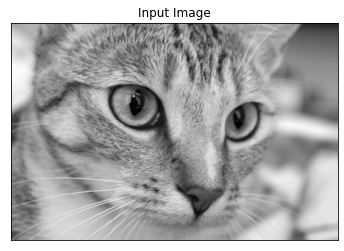

In [9]:
# Show results

fig0, ax0 = plt.subplots(nrows=1, ncols=1)
ax0.imshow(img).set_cmap("gray")
ax0.set_title("Input Image")
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
plt.show()


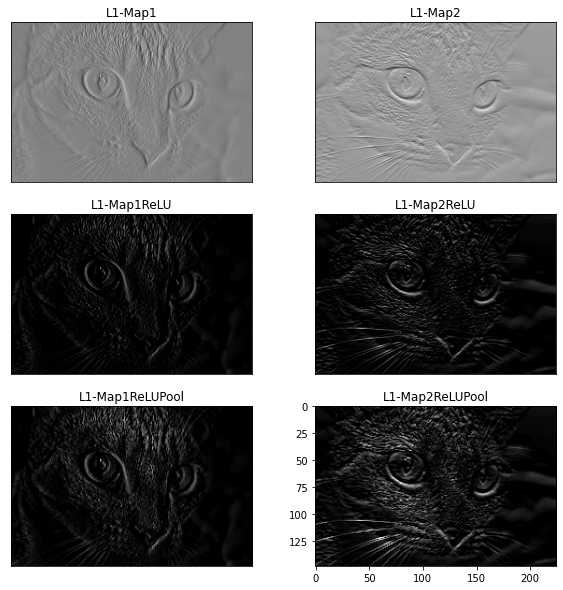

In [10]:
# Layer 1
fig1, ax1 = plt.subplots(nrows=3, ncols=2)
fig1.set_figheight(10)
fig1.set_figwidth(10)
ax1[0, 0].imshow(l1_feature_maps[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_maps[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")

plt.show()


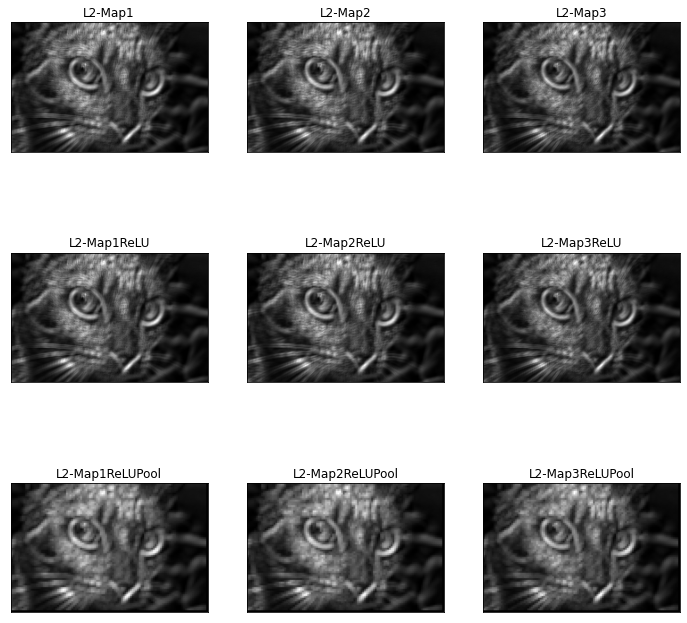

In [11]:
# Layer 2
fig2, ax2 = plt.subplots(nrows=3, ncols=3)
fig2.set_figheight(12)
fig2.set_figwidth(12)
ax2[0, 0].imshow(l2_feature_maps[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_maps[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_maps[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_maps_relu[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_maps_relu_pool[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")
plt.show()

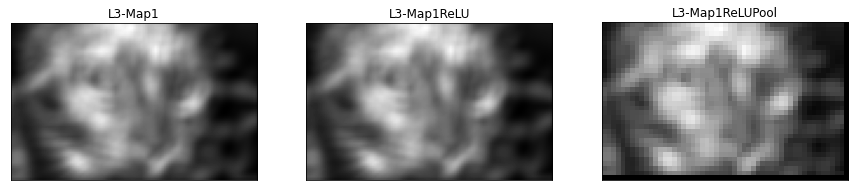

In [12]:
# Layer 3

fig3, ax3 = plt.subplots(nrows=1, ncols=3)
fig3.set_figheight(15)
fig3.set_figwidth(15)
ax3[0].imshow(l3_feature_maps[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool")
plt.show()